In [1]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from copy import deepcopy
import random
from tqdm import tqdm
from collections import defaultdict
import mysql.connector
import json
import pickle
import requests
from cs411_util import generate_graphs, get_pub_info_from_mysql

## Collect data

### MAG_CS

In [2]:
data_dir = 'MAG_0919_CS/'
Papers = data_dir + 'Papers_CS_20190919.tsv'
papers_df = pd.read_csv(Papers, sep='\t')
papers_df.head()

,PaperId,PublishYear,NormalizedTitle,VenueId,DetectedLanguage,DocType,EstimatedCitation
0,2357104884,2002,on the position and function of references in ...,2764343798,NaN,Journal,0
1,2367103297,2003,technology of modeling on multimedia simulatio...,2764343798,NaN,Journal,0
2,2374179795,2001,synchronization after stepout in the exciting ...,2764343798,NaN,Journal,0
3,2382299349,2005,the design for lumping monitored control syste...,2764343798,NaN,Journal,0
4,2378847813,2005,the communication method between ironmaking ma...,2764343798,NaN,Journal,0


In [3]:
pid2infos = {item['PaperId'] : {'title' : item['NormalizedTitle'], 'year' : item['PublishYear']} for item in tqdm(papers_df[['PaperId', 'NormalizedTitle', 'PublishYear']].to_dict('records'))}

100%|██████████| 5597605/5597605 [00:05<00:00, 1073874.36it/s]


In [4]:
PAb = data_dir + 'PAb_CS_20190919.tsv'
pab_df = pd.read_csv(PAb, sep='\t')
pab_df.head()

,PaperId,Abstract
0,1963479517,This study investigated EFL learners' online r...
1,2095588566,Based on the concept of credibility and a new ...
2,1963479629,Virtualization technology has shown immense po...
3,1819117914,Serious games have recently emerged as an aven...
4,2095588629,"In this paper, we propose an unequal error pro..."


In [5]:
pid2abs = {item['PaperId'] : item['Abstract'] for item in tqdm(pab_df.to_dict('records'))}

100%|██████████| 4541447/4541447 [00:02<00:00, 1539490.33it/s]


In [6]:
PAuAf = data_dir + 'PAuAf_CS_20190919.tsv'
pauaf_df = pd.read_csv(PAuAf, sep='\t')
pauaf_df.head()

,PaperSeqid,AuthorSeqid,AffiliationSeqid,AuthorSequenceNumber
0,1963479517,2167258348,134161618.0,2
1,1963479517,2506097535,134161618.0,3
2,1963479517,2296113232,142823887.0,1
3,2095588566,2439736113,NaN,2
4,2095588566,2575410839,NaN,1


In [7]:
pid2magfids = defaultdict(list)
magfid2pids = defaultdict(list)
for item in tqdm(pauaf_df[['PaperSeqid', 'AuthorSeqid']].to_dict('records')):
    pid2magfids[item['PaperSeqid']].append(item['AuthorSeqid'])
    magfid2pids[item['AuthorSeqid']].append(item['PaperSeqid'])

fname2magfids = defaultdict(list)
magfid2fname = {}
for item in tqdm(pd.read_csv('SeqName_CS_20190919.tsv', sep='\t', header=None).to_dict('records')):
    if item[2] == 'author':
        fname2magfids[item[1].lower()].append(item[0])
        magfid2fname[item[0]] = item[1].lower()

100%|██████████| 6149660/6149660 [00:17<00:00, 349848.30it/s]


In [8]:
co_author_graph = nx.Graph()
for pid, info in tqdm(pid2infos.items()):
    info['abstract'] = pid2abs.get(pid)
    co_authors = pid2magfids.get(pid)
    info['authors'] = co_authors
    for i in range(len(co_authors)):
        for j in range(i+1, len(co_authors)):
            if not co_author_graph.has_edge(co_authors[i], co_authors[j]):
                co_author_graph.add_edge(co_authors[i], co_authors[j], c=0)
            co_author_graph.get_edge_data(co_authors[i], co_authors[j])['c'] += 1

100%|██████████| 5597605/5597605 [02:19<00:00, 40018.43it/s] 


In [9]:
with open('magfid2pids.pickle', 'wb') as f_out:
    pickle.dump(magfid2pids, f_out)
with open('pid2magfids.pickle', 'wb') as f_out:
    pickle.dump(pid2magfids, f_out)
with open('fname2magfids.pickle', 'wb') as f_out:
    pickle.dump(fname2magfids, f_out)
with open('pid2infos.pickle', 'wb') as f_out:
    pickle.dump(pid2infos, f_out)
with open('magfid2fname.pickle', 'wb') as f_out:
    pickle.dump(magfid2fname, f_out)
nx.write_gpickle(co_author_graph, 'co_author.gpickle')
print('done')

done


In [ ]:
for n in co_author_graph.nodes:
    nbr = list(co_author_graph.neighbors(n))[0]
    print((n, nbr))
    print(co_author_graph.get_edge_data(n, nbr))
    break

In [ ]:
for item in pid2infos.items():
    print(item)
    break

In [ ]:
for item in magfid2pids.items():
    print(item)
    break

### AcademicWorld

In [10]:
with open('faculty.json') as f_in:
    faculty = json.load(f_in)
with open('publications.json') as f_in:
    publications = json.load(f_in)

In [11]:
awfid2pids = {item['id'] : item['publications'] for item in faculty}
fname2awfids = defaultdict(list)
awfid2fname = {}
for item in faculty:
    fname2awfids[item['name'].lower()].append(item['id'])
    awfid2fname[item['id']] = item['name'].lower()
pid2awfids = defaultdict(list)
for fid, pids in awfid2pids.items():
    for pid in pids:
        pid2awfids[pid].append(fid)

In [12]:
with open('awfid2pids.pickle', 'wb') as f_out:
    pickle.dump(awfid2pids, f_out)
with open('pid2awfids.pickle', 'wb') as f_out:
    pickle.dump(pid2awfids, f_out)
with open('fname2awfids.pickle', 'wb') as f_out:
    pickle.dump(fname2awfids, f_out)
with open('awfid2fname.pickle', 'wb') as f_out:
    pickle.dump(awfid2fname, f_out)

## Sentence transformers

In [2]:
co_author_graph = nx.read_gpickle('co_author.gpickle')

In [4]:
with open('pid2infos.pickle', 'rb') as f_in:
    pid2infos = pickle.load(f_in)
with open('magfid2pids.pickle', 'rb') as f_in:
    magfid2pids = pickle.load(f_in)

In [5]:
# Split publications by year
known_pids = {pid for pid, info in pid2infos.items() if info['year'] <= 2016}
unknown_pids = {pid for pid, info in pid2infos.items() if info['year'] > 2016}

In [6]:
test_authors = [aid for aid, pids in magfid2pids.items() if any([pid in known_pids for pid in pids]) and any([pid in unknown_pids for pid in pids])]

In [7]:
len(test_authors)

402728

In [8]:
model = SentenceTransformer('allenai-specter').eval()

In [10]:
pos_test_similarities = []
for aid in tqdm(test_authors[:500]):
    known_pubs = [pid for pid in magfid2pids[aid] if pid in known_pids and pid2infos[pid]['abstract'] is not None]
    unknown_pubs = [pid for pid in magfid2pids[aid] if pid in unknown_pids and pid2infos[pid]['abstract'] is not None]
    if (not known_pubs) or (not unknown_pubs):
        continue
    known_emb = model.encode(['%s[SEP]%s' % (pid2infos[pid]['title'], pid2infos[pid]['abstract']) for pid in known_pubs], convert_to_tensor=True)
    unknown_emb = model.encode(['%s[SEP]%s' % (pid2infos[pid]['title'], pid2infos[pid]['abstract']) for pid in unknown_pubs], convert_to_tensor=True)
    search_hits = util.semantic_search(unknown_emb, known_emb, top_k=1)
    pos_test_similarities.extend([hit[0]['score'] for hit in search_hits])

100%|██████████| 500/500 [01:52<00:00,  4.46it/s]


6157


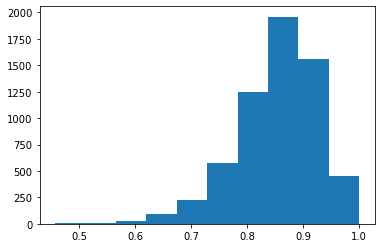

In [11]:
print(len(pos_test_similarities))
plt.hist(pos_test_similarities)
plt.show()

In [14]:
neg_test_similarities = []
temp_test_authors = deepcopy(test_authors)
random.seed(0)
random.shuffle(temp_test_authors)
for idx, aid in enumerate(tqdm(temp_test_authors[:1000])):
    known_pubs = [pid for pid in magfid2pids[aid] if pid in known_pids and pid2infos[pid]['abstract'] is not None]
    unknown_pubs = [pid for pid in magfid2pids[temp_test_authors[idx+1]] if pid in unknown_pids and pid2infos[pid]['abstract'] is not None]
    if (not known_pubs) or (not unknown_pubs):
        continue
    known_emb = model.encode(['%s[SEP]%s' % (pid2infos[pid]['title'], pid2infos[pid]['abstract']) for pid in known_pubs], convert_to_tensor=True)
    unknown_emb = model.encode(['%s[SEP]%s' % (pid2infos[pid]['title'], pid2infos[pid]['abstract']) for pid in unknown_pubs], convert_to_tensor=True)
    search_hits = util.semantic_search(unknown_emb, known_emb, top_k=1)
    neg_test_similarities.extend([hit[0]['score'] for hit in search_hits])

100%|██████████| 1000/1000 [00:50<00:00, 19.65it/s]


3115


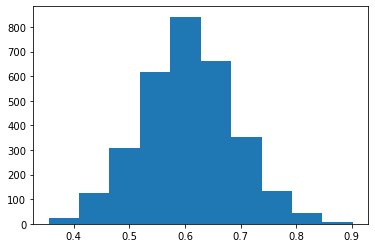

In [15]:
print(len(neg_test_similarities))
plt.hist(neg_test_similarities)
plt.show()

In [16]:
# Recall
len([1 for score in pos_test_similarities if score > 0.73]) / len(pos_test_similarities)

0.9420172161767094

In [17]:
# Precision
len([1 for score in pos_test_similarities if score > 0.73]) / (len([1 for score in pos_test_similarities if score > 0.7]) + len([1 for score in neg_test_similarities if score > 0.7]))

0.9139615505830444

In [18]:
# Accuracy
(len([1 for score in pos_test_similarities if score > 0.73]) + len([1 for score in neg_test_similarities if score <= 0.7])) / (len(pos_test_similarities) + len(neg_test_similarities))

0.9187877480586712

## Demo

In [2]:
# Load resources
with open('awfid2pids.pickle', 'rb') as f_in:
    awfid2pids = pickle.load(f_in)
with open('pid2awfids.pickle', 'rb') as f_in:
    pid2awfids = pickle.load(f_in)
with open('fname2awfids.pickle', 'rb') as f_in:
    fname2awfids = pickle.load(f_in)
with open('magfid2pids.pickle', 'rb') as f_in:
    magfid2pids = pickle.load(f_in)
with open('pid2magfids.pickle', 'rb') as f_in:
    pid2magfids = pickle.load(f_in)
with open('fname2magfids.pickle', 'rb') as f_in:
    fname2magfids = pickle.load(f_in)
with open('awfid2fname.pickle', 'rb') as f_in:
    awfid2fname = pickle.load(f_in)
    
with open('pid2infos.pickle', 'rb') as f_in:
    pid2infos = pickle.load(f_in)
with open('magfid2fname.pickle', 'rb') as f_in:
    magfid2fname = pickle.load(f_in)
    
db = mysql.connector.connect(user='mag_readonly', password='j6gi48ch82nd9pff', host="mag-2020-09-14.mysql.database.azure.com",
   port=3306,
   database='mag_2020_09_14',
   ssl_ca="DigiCertGlobalRootCA.crt.pem",
   ssl_disabled=False)
cursor = db.cursor()

sentence_transformer = SentenceTransformer('allenai-specter').cuda()

In [3]:
target_author_name = list(set(fname2awfids.keys()) & set(fname2magfids.keys()))[4]
target_author_id = fname2awfids[target_author_name][0]

test_pid = -1
for fid in fname2magfids[target_author_name]:
    try:
        for pid in magfid2pids[fid]:
            if pid2infos[pid]['abstract'] is not None and len(pid2infos[pid]['authors']) >= 2:
                test_pid = pid
                break
        if test_pid >= 0:
            break
    except:
        pass
if test_pid >= 0:
    test_pub = {'title': pid2infos[test_pid]['title'],
                'abstract' : pid2infos[test_pid]['abstract'],
                'co_author' : [magfid2fname[fid] for fid in pid2infos[test_pid]['authors']]}
    print(target_author_id)
    print(test_pub)

2404
{'title': 'designing energy efficient convolutional neural networks using energy aware pruning', 'abstract': 'Deep convolutional neural networks (CNNs) are indispensable to state-of-the-art computer vision algorithms. However, they are still rarely deployed on battery-powered mobile devices, such as smartphones and wearable gadgets, where vision algorithms can enable many revolutionary real-world applications. The key limiting factor is the high energy consumption of CNN processing due to its high computational complexity. While there are many previous efforts that try to reduce the CNN model size or the amount of computation, we find that they do not necessarily result in lower energy consumption. Therefore, these targets do not serve as a good metric for energy cost estimation. To close the gap between CNN design and energy consumption optimization, we propose an energy-aware pruning algorithm for CNNs that directly uses the energy consumption of a CNN to guide the pruning proce

In [7]:
type(cursor)

mysql.connector.cursor_cext.CMySQLCursor

In [19]:
# sentence transformer score
known_pids = awfid2pids[target_author_id]
known_pubs = get_pub_info_from_mysql(known_pids, cursor)
known_emb = sentence_transformer.encode(['%s[SEP]%s' % (str(info.get('title')), str(info.get('abstract'))) for pid, info in known_pubs.items()], convert_to_tensor=True).cuda()
unknown_emb = sentence_transformer.encode(['%s[SEP]%s' % (test_pub['title'], test_pub['abstract'])], convert_to_tensor=True).cuda()
search_hits = util.semantic_search(unknown_emb, known_emb, top_k=1)
semantic_score = search_hits[0][0]['score']
semantic_score

0.9999547004699707

## REST API

In [4]:
r = requests.get(url='http://128.174.136.27:5000', params={'target' : target_author_id, 'title' : test_pub['title'], 'abstract' : test_pub['abstract']})

In [5]:
r.content

b'{"belongs":true,"score":0.9999966621398926,"semantic_score":0.9999966621398926}\n'

In [ ]:
co_author = 'Jiawei Han'
aw_candidate_ids = fname2awfids.get(co_author.lower())
if aw_candidate_ids is not None:
    aw_graphs = generate_graphs(aw_candidate_ids, awfid2pids, pid2awfids)

mag_candidate_ids = fname2magfids.get(co_author.lower())
if mag_candidate_ids is not None:
    mag_graphs = generate_graphs(mag_candidate_ids, magfid2pids, pid2magfids)

In [ ]:
max([len(list(mag_graphs[i].nodes)) for i in range(len(mag_graphs))])

In [ ]:
mag_graphs[0].nodes[2721444824]['pids']

In [ ]:
cursor.execute('show databases;')

In [ ]:
cursor.execute('use mag_2020_09_14;')

In [ ]:
cursor.execute('show tables;')

In [ ]:
cursor.execute('describe paperauthoraffiliations;')

In [11]:
cursor.execute('describe papers;')

In [14]:
myresult = cursor.fetchall()
for x in myresult:
    print(x)

(143843904, 'thermal aware cad for modern integrated circuits')
(1990758031, 'a decap placement methodology for reducing joule heating and temperature in psn interconnect')
(2055008360, 'fast thermal aware floorplanning using white space optimization')
(2074342132, 'redundant c4 power pin placement to ensure robust power grid delivery')
(2121142867, 'package chip co design to increase flip chip c4 reliability')
(2122621647, 'a model for rolling swarms of locusts')
(2203556365, 'systems and methods for integrated circuit c4 ball placement')
(2279021877, 'methods and systems for integrated circuit c4 ball placement')
(2983968810, 'aerodynamics of wiffle balls')
(3047808303, 'experimental investigation of the aerodynamic forces on a curveball')


In [ ]:
cursor.execute('select Abstract from paperabstracts where PaperId in (%s)' % ','.join([str(pid) for pid in mag_graphs[0].nodes[2721444824]['pids']]))

In [13]:
cursor.execute('select PaperId, PaperTitle from papers where PaperId in (%s)' % ','.join([str(pid) for pid in known_pubs]))

In [ ]:
cursor.execute('select * from authors where DisplayName="Jiawei Han" limit 5')

In [ ]:
cursor.execute('select * from paperauthoraffiliations where PaperId=21366')